In [4]:
%matplotlib inline
import sys
from lib.restartable_pendulum import RestartablePendulumEnv
from lib import state_rep_torch as srt
import gym
import numpy as np
from matplotlib import pyplot as plt
import torch
from lib import utils
from lib import encoder_wrappers as ew

# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

%load_ext autoreload
%autoreload 2


save_dir = "./"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mixture of LDS with regularization (n_repeats=2)

/home/holdenlee/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


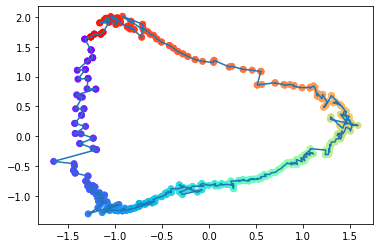

In [2]:
# specify environment information
n_repeats = 2 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)


#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 3] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,6,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed")

torch.save(net,save_dir+"/normed.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

# Mixture of LDS with regularization (n_repeats=3)

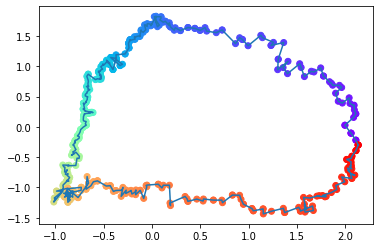

In [5]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)


#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 3] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,6,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3")

torch.save(net,save_dir+"/normed3.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

In [13]:
save_dir = "./"
net = torch.load(save_dir+"/normed3.net")
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)
# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
#xhat = utils.visualize_trajectory_aligned(X)
#X
mix_weights = net.mixer(torch.from_numpy(X).float())
#https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
for i in range(n_samps):
    wts = mix_weights[i].detach().numpy()
    print(np.argmax(wts), wts)

3 [0.38807768 0.0216322  0.10246757 0.40884134 0.04845151 0.03052967]
3 [0.40226102 0.02100195 0.09222756 0.40673104 0.0495013  0.02827711]
3 [0.40226102 0.02100195 0.09222756 0.40673104 0.0495013  0.02827711]
3 [0.40555927 0.02152528 0.08547808 0.40802583 0.0512468  0.02816482]
3 [0.40555927 0.02152528 0.08547808 0.40802583 0.0512468  0.02816482]
3 [0.40555927 0.02152528 0.08547808 0.40802583 0.0512468  0.02816482]
3 [0.40514946 0.02252342 0.0798481  0.41025257 0.05345716 0.02876928]
3 [0.40514946 0.02252342 0.0798481  0.41025257 0.05345716 0.02876928]
3 [0.4076538  0.02051809 0.06744587 0.4297287  0.04796121 0.02669234]
3 [0.40773642 0.01999554 0.06319217 0.43653426 0.04642351 0.02611817]
3 [0.40773642 0.01999554 0.06319217 0.43653426 0.04642351 0.02611817]
3 [0.4169398  0.01946714 0.05795998 0.4342018  0.04684181 0.02458933]
3 [0.40361783 0.02026631 0.05745606 0.4462389  0.04599445 0.02642641]
3 [0.42281815 0.01900529 0.0533537  0.4346312  0.04671652 0.02347508]
3 [0.41299972 0.0202

# Control: no forward loss, regularization only

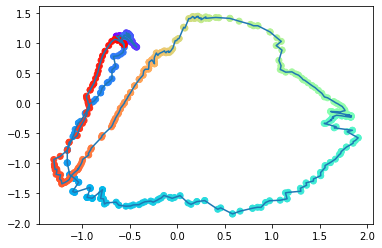

In [3]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)


#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 3] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,6,mixnet,alpha=0,mean_coeff = 1, covar_coeff=1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed_only")

torch.save(net,save_dir+"/normed_only.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

# LDS (n_repeats=3)

/home/holdenlee/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


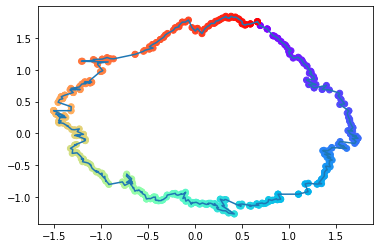

In [2]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)
enc_dim = 3

#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
#mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.ForwardNet(encnet,layers[-1],1,mean_coeff = 1.0/enc_dim, covar_coeff=1.0/enc_dim)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed_linear")

torch.save(net,save_dir+"/normed_linear.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

# 10-dimensional representation

In [4]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)
enc_dim = 10

#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
#mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.ForwardNet(encnet,layers[-1],1,mean_coeff = 1.0/enc_dim, covar_coeff=1.0/enc_dim)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed_linear_10")

torch.save(net,save_dir+"/normed_linear_10.net")




ValueError: shapes (3,3) and (10,) not aligned: 3 (dim 1) != 10 (dim 0)

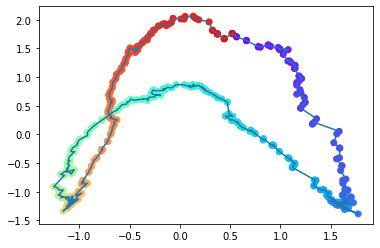

In [5]:

# what follows is code to visualize the representations
d = enc_dim # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

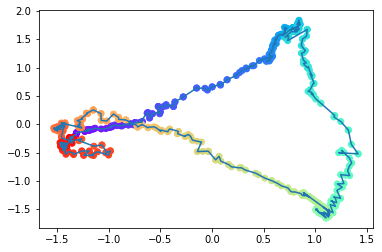

In [9]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=10
#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([10,20])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,20,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_10")

torch.save(net,save_dir+"/normed3_10.net")



# what follows is code to visualize the representations
d = enc_dim # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

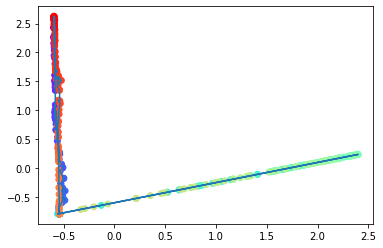

In [7]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=10
#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 256
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([10,20])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,20,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_10_256")

torch.save(net,save_dir+"/normed3_10_256.net")



# what follows is code to visualize the representations
d = enc_dim # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

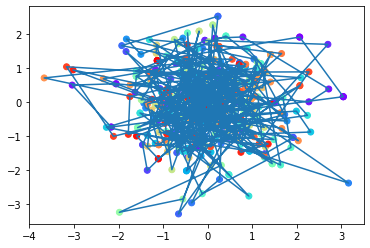

In [8]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=10
#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 256
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([10,20])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,20,mixnet,alpha=1,mean_coeff = 0.3, covar_coeff=0.1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_10_256")

torch.save(net,save_dir+"/normed3_10_256.net")



# what follows is code to visualize the representations
d = enc_dim # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

# With projection loss

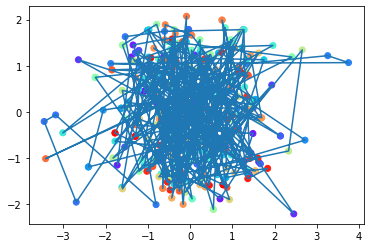

In [10]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=10
#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, enc_dim] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 256
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([10,20])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,20,mixnet,alpha=1,mean_coeff = 1.0, covar_coeff=0, proj_coeff=0.1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_10_proj")

torch.save(net,save_dir+"/normed3_10_proj.net")



# what follows is code to visualize the representations
d = enc_dim # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

# 3-dim with random

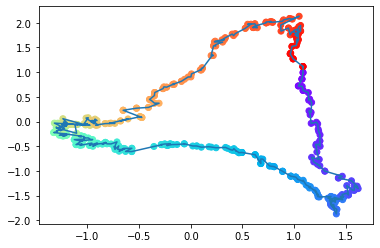

In [5]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=3

#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 3] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,6,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1, random_inputs=True, random_inputs_weight=0.001)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_random")

torch.save(net,save_dir+"/normed3_random.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)

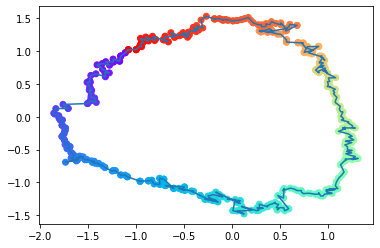

In [6]:
# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)

enc_dim=3

#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 3] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 64
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)
mixnet = srt.SoftmaxNet([3,6])

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

#0.1,0,10
#prednet = srt.ForwardNet(encnet,layers[-1],1)
#mixture of 5
prednet = srt.MixtureForwardNet(encnet,layers[-1],1,6,mixnet,alpha=1,mean_coeff = 1, covar_coeff=1, random_inputs=True, random_inputs_weight=0.0)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch_zero,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir+"/normed3_random0")

torch.save(net,save_dir+"/normed3_random0.net")



# what follows is code to visualize the representations
d = 3 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
    #env.render()
xhat = utils.visualize_trajectory_aligned(X)